<a href="https://colab.research.google.com/github/dinoskos/Neural-Networks-Learning-Guide/blob/main/Pretraining_Guide_for_FFNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Guide to Train a Next Token Prediction Simple Feedforward Neural Network using PyTorch**



## **Introduction to Feedforward Neural Networks**

A feedforward neural network (FNN) is the simplest type of neural network. It consists of layers of neurons where the data moves forward in one direction.

In this guide, we will pretrain a simple FNN using text data extracted from PDF files. The model learns to predict the next word in a sequence using context words. Each step of the process is detailed below. The workflow below is taken from Jurafsky and Martin book on Speech and Language Processing.

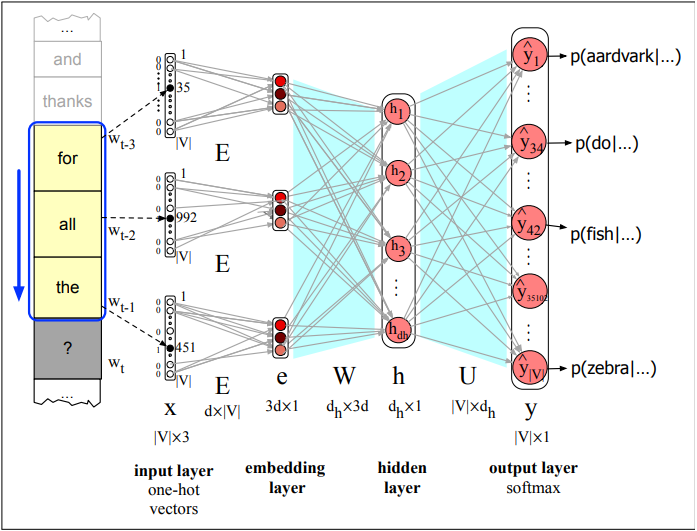

## **Understanding the Network Architecture**

Our neural network consists of the following components:

1. **Input Layer**

- Each word in the vocabulary is represented by a one-hot encoded vector of shape $[|V|, 1]$, where $|V|$ is the vocabulary size.
- Example: Suppose we have a phrase **"I like apple"**, and assume the vocabulary indices are:
  - **"I"** → Index $2$
  - **"like"** → Index $10$
  - **"apple"** → Index $60$

**The one-hot representations are:**

$$
\begin{align}
I      &= [0, 0, 1, \dots, 0] \quad \text{(one-hot vector with 1 at index 2)} \\
\text{like} &= [0, 0, 0, \dots, 1, 0, 0, \dots, 0] \quad \text{(1 at index 10)} \\
\text{apple} &= [0, 0, 0, \dots, 1, 0, 0] \quad \text{(1 at index 60)}
\end{align}
$$

2. **Embedding Layer**
- Converts one-hot vectors into dense word embeddings of size *d*.
- We define an embedding matrix *E* of shape $[d, V]$, where"
    - *d* = Embedding dimension
    - *|V|* = Vocabulary size
- The embedding layer is computed as:

$$
  \text{embedding_layer} = E \times \text{token_vector}
$$

$$
  = [d, |V|] \times [|V|,1]] = [d, 1]
$$


3. **Fully Connected Layers**

- *First layer*
    - Linear transformation followed by *ReLU activation*.
    - Takes input from the embedding layer and maps it to a hidden layer.
    - Equation:
$$
 \text{hidden_layer} = ReLU(W \times \text{embedding_layer} + \text{bias})
$$

$$
  = ReLU([d_{\text{hidden}}, d] \times [d,1] + [b, 1])
$$

$$
  = RELU([d_{\text{hidden}},1] + [b, 1])
$$

$$
 = RELU([y_{\text{hidden}}, 1])
$$

$$
 = [y_d, 1]
$$

- *Second layer*
    - Maps the hidden representation to the output vocabulary using a softmax activation function.
    - The final pre-output is:
      $$
  \text{pre_output} = U \times \text{hidden_layer} = [V, y_d] \times [y_d, 1] = [V, 1]
  $$

    - Applying softmax gives the probability distribution over words:
      $$
  \text{output} = \text{softmax}(\text{pre_output}) = [V, 1]
  $$


**Recap of Input/Output Shape Flow**  

Start:  
- Supposedly, we have 3 tokens, each represented as a vector of shape 3 x \[V, 1] \.  
- An embedding matrix of shape \( [d, V] \) maps tokens into a dense representation.  
- Each token vector is multiplied by the embedding matrix to obtain a representation in the embedding layer:
  
  $$
  \text{embedding_layer} = \text{embedding_matrix} \times 3 \times \text{token_vector}
  $$

  $$
  = 3 \times [d, |V|] \times [|V|,1] = 3 \times [d,1]
  $$

- Next, we perform a linear transformation:

  $$
  W \times \text{embedding_layer} + \text{bias}
  $$

  $$
  = [d_{\text{hidden}}, d] \times [d,1] + [b, 1] = [d_{\text{hidden}},1] + [b, 1] = [y_{\text{hidden}}, 1]
  $$

- We then apply an activation function:

  $$
  \text{hidden_layer} = \text{ReLU}(y_{\text{hidden}}) = [y_d, 1]
  $$

- The hidden layer is then projected to the output space using a weight matrix \( U \):

  $$
  \text{pre_output} = U \times \text{hidden_layer} = [V, y_d] \times [y_d, 1] = [V, 1]
  $$

- Finally, we apply the softmax function to obtain the probability distribution over the output vocabulary:

  $$
  \text{output} = \text{softmax}(\text{pre_output}) = [V, 1]
  $$

## Training Process

The training process involves the following steps:

1.   **Preprocess Data**: Extract text from PDFs, tokenize, and build a vocabulary.
2.   **Generate Training Data**: Create (context, target word) training pairs.
3.   **Convert Data to Tensors**: Use PyTorch to format inputs for training.
4.   **Define Model Architecture**: Build a simple FNN with embedding and dense layers.
5.   **Train the Model**: Optimize using Cross-Entropy Loss and Adam Optimizer.


## Implementation in Google Collab

In [4]:
# Installing required ibrary
!pip install langchain-community pypdf

In [5]:
# Loading library
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import Counter
import os
from google.colab import userdata, drive
from langchain.document_loaders import PyPDFLoader

In [6]:
# Login to drive
drive.mount('/content/drive')

Mounted at /content/drive


Supposedly you have a bunch of PDF files in a folder you want to pretrain your model, you can use the glob package to itteratively read them into a docs.

In [7]:
# Define the folder containing PDFs in Google Drive
pdf_folder_path = '/content/drive/MyDrive/Project/I-OLLM/data_2' # path where you store your pdf

# Use glob to list all PDF files in the folder
pdf_files = glob.glob(f"{pdf_folder_path}/*.pdf")

# Load PDFs using PyPDFLoader
docs = []
for pdf_file in pdf_files:
    pdf_loader = PyPDFLoader(pdf_file)
    docs.extend(pdf_loader.load())  # Extend the list with documents from each PDF

In [8]:
# Extract text from loaded PDFs
words = []
for doc in docs:
    words.extend(doc.page_content.split())

In [9]:
# Build vocabulary
vocab = Counter(words)
vocab = {word: i for i, (word, _) in enumerate(vocab.most_common(200000))}  # Limit vocab size
print(f'Total length of our vocabulary is {len(vocab)}')

Total length of our vocabulary is 15302


In [10]:
# Generate training data
context_size = 5  # Small context window
training_data = []

for i in range(context_size, len(words)):
    context = [words[i - j] for j in range(1, context_size + 1)]  # Only preceding words
    target = words[i]
    if target in vocab and all(word in vocab for word in context):
        training_data.append(([vocab[word] for word in context], vocab[target]))

In [11]:
# Convert to PyTorch tensors
X_train = torch.tensor([pair[0] for pair in training_data], dtype=torch.long)
y_train = torch.tensor([pair[1] for pair in training_data], dtype=torch.long)

In [12]:
# Define feedforward neural network archetecture
class SimpleNN(nn.Module):
    """
    A simple feedforward neural network for word prediction.

    Attributes:
        embedding (nn.Embedding): Converts token indices into dense word vectors.
        fc1 (nn.Linear): Fully connected hidden layer.
        fc2 (nn.Linear): Output layer mapping hidden representation to vocabulary.
    """
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(SimpleNN, self).__init__()

        # Embedding layer: Transforms word indices into dense vectors
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # Fully connected layers
        self.fc1 = nn.Linear(embed_size * context_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        """
        Forward pass of the neural network.

        Args:
            x (torch.Tensor): Input tensor containing word indices.

        Returns:
            torch.Tensor: Logits over vocabulary.
        """
        x = self.embedding(x)  # Convert indices to embeddings
        x = x.view(x.size(0), -1)  # Flatten embeddings
        x = torch.relu(self.fc1(x))  # Apply activation
        x = self.fc2(x)  # Output logits
        return x

In [13]:
# Model parameters
vocab_size = len(vocab)
embed_size = 500
hidden_size = 256

model = SimpleNN(vocab_size, embed_size, hidden_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

Start our model training with the following code:

In [14]:
# Training loop
epochs = 5
batch_size = 128

for epoch in range(epochs):
    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        batch_x = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(X_train):.6f}")

Epoch 1/5, Loss: 0.058551
Epoch 2/5, Loss: 0.041420
Epoch 3/5, Loss: 0.026378
Epoch 4/5, Loss: 0.015855
Epoch 5/5, Loss: 0.008409


**And you are done!**

Now supposedly you want to use your model to prediction given some tokens. Here is how we do it.


In [15]:
model.eval()

# Define the input phrase
input_text = ["Although", "we", "have", "describe", "different"]

In [16]:
if all(word in vocab for word in input_text):
    input_indices = torch.tensor([[vocab[word] for word in input_text]], dtype=torch.long)

    # Make a prediction
    with torch.no_grad():
        output = model(input_indices)

    # Get the predicted word index
    top_k = 3  # Get top 3 predictions
    top_indices = torch.topk(output, top_k, dim=1).indices.squeeze(0).tolist()

    predicted_words = [next(word for word, index in vocab.items() if index == idx) for idx in top_indices]
    print("Top 3 predicted words:", predicted_words)
else:
    print("One or more words in the input phrase are not in the vocabulary.")

Top 3 predicted words: ['the', 'this', 'there']


In [17]:
#Examining weights
embedding_weights = model.embedding.weight.data
print("Embedding Layer Weights Shape:", embedding_weights.shape)

fc1_weights = model.fc1.weight.data
fc1_bias = model.fc1.bias.data

print("FC1 Weights Shape:", fc1_weights.shape)
print("FC1 Bias Shape:", fc1_bias.shape)

Embedding Layer Weights Shape: torch.Size([15302, 500])
FC1 Weights Shape: torch.Size([256, 2500])
FC1 Bias Shape: torch.Size([256])
